In [1]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import HTML

#print("PyTorch version {}".format(torch.__version__))
#print("PyG version {}".format(torch_geometric.__version__))

In [2]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed(0)

In [3]:
#dat = torch.load('graphs.pt', weights_only=False)
#dat

In [4]:
def print_info(dat, index):
    print("Data Object: ", dat[index])
    print("Features: ", dat[index].x)
    print("Edges: ", dat[index].edge_index)
    print("Edge Attr: ", dat[index].edge_attr)
    print("Target: ", dat[index].y)
#dat1[9]

In [5]:
def load_clean_data(fname):
    dat = torch.load(fname, weights_only=False)
    dat1 = dat.copy()
    dat_new = []
    for d in dat1:
        bad_smiles = ['[2H]C([2H])Br',
 '[2H]C([2H])([2H])C(=O)C([2H])([2H])[2H]',
 '[H-].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[Co]',
 '[H-].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[Mn]',
 '[CH2]O.[CH2]O.[CH2]O.[CH2]O.[CH2]O.[CH2]O.[CH2]O.[CH2]O.[CH2]O.[CH]O.[CH]O.[CH]O.[Co].[Co].[Co].[Fe].[H]']
        if d.smile in bad_smiles:
            print("Bad Smile Found")
            del d
            continue
       # del d.smile
        d.x = torch.tensor(d.x.astype("float32"), dtype=torch.float32)
        d.x=torch.nan_to_num(d.x, nan=-1)
        d.y=torch.tensor(d.y.astype("float32"), dtype=torch.float32)
        d.y = torch.nan_to_num(d.y, nan=-1)
        d.edge_attr=torch.tensor(d.edge_attr, dtype=torch.float32)
        d.edge_index=torch.tensor(d.edge_index, dtype=torch.long)
        del d.smile
        dat_new = dat_new+[d]
    return dat1, dat_new

In [6]:
# Feat = [atomic number, formal charge, eneg enviroment, orbital id, orbital id, ref energy]
dat1, dat_new = load_clean_data('graphs.pt')
len(dat_new)

Bad Smile Found
Bad Smile Found
Bad Smile Found
Bad Smile Found
Bad Smile Found


/tmp/ipykernel_11545/3453532925.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d.edge_attr=torch.tensor(d.edge_attr, dtype=torch.float32)
/tmp/ipykernel_11545/3453532925.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d.edge_index=torch.tensor(d.edge_index, dtype=torch.long)


1158

In [7]:
print_info(dat1,2)

Data Object:  Data(x=[22, 6], edge_index=[2, 231], edge_attr=[231, 1], y=[22])
Features:  tensor([[ 6.0000e+00,  0.0000e+00,  1.0500e+00,  1.0000e+00,  0.0000e+00,
          3.0824e+02],
        [ 6.0000e+00,  0.0000e+00, -8.9000e-01,  1.0000e+00,  0.0000e+00,
          3.0824e+02],
        [ 6.0000e+00,  0.0000e+00,  3.5000e-01,  1.0000e+00,  0.0000e+00,
          3.0824e+02],
        [ 6.0000e+00,  0.0000e+00, -8.9000e-01,  1.0000e+00,  0.0000e+00,
          3.0824e+02],
        [ 8.0000e+00,  0.0000e+00,  8.9000e-01,  1.0000e+00,  0.0000e+00,
          5.6284e+02],
        [ 6.0000e+00,  0.0000e+00,  1.0500e+00,  1.0000e+00,  0.0000e+00,
          3.0824e+02],
        [ 8.0000e+00,  0.0000e+00,  2.7200e+00,  1.0000e+00,  0.0000e+00,
          5.6284e+02],
        [ 1.3000e+01,  0.0000e+00, -5.4900e+00,  2.0000e+00,  1.0000e+00,
          8.7515e+01],
        [ 8.0000e+00,  0.0000e+00,  2.7200e+00,  1.0000e+00,  0.0000e+00,
          5.6284e+02],
        [ 6.0000e+00,  0.0000e+00, -8

In [8]:
new_dataset=dat_new

In [9]:
import random
print(f"Total number of samples: {len(new_dataset)}.")
random.shuffle(new_dataset)
# Split datasets
train_dataset = new_dataset[:930]
val_dataset = new_dataset[930:1046]
test_dataset = new_dataset[1046:1163]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 1158.
Created dataset splits with 930 training, 116 validation, 112 test samples.


In [10]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=1, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)
        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [11]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=73, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
      #  print("H Shape: ", h.shape)
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = h#self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (target_size, d) -> (target_size, 1)
       
        return out#.view(-1)

In [12]:
# Train
def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0
    len_all = 0
    for data in train_loader:
        data=data.to(device)
        optimizer.zero_grad()
    #    print("Data.x: ", data.x)
   #     print("Data edge index: ", data.edge_index)
     #   print("")
        out = model(data)
        #out = model(data.x, data.edge_index)
        # replace any energy with -1 if corr. orbital is -100
        mask=torch.any(data.x==-100, dim=1)
        out[mask]=-1

    #    print("pred shape: ", out.shape)
     #   print("act shape: ", data.y.shape)
      #  print("y_pred: ", out)
    #    print("y_act: ", data.y)
        
        # remove null energy=-1/orb=-100 values, then calculate loss
        pred1 = out[out!=-1]
        act1 = data.y[data.y!=-1]
      #  ref_e = data.x[:,-1]
       # print("Check ref_e: ", ref_e)
        loss = F.l1_loss(pred1, act1) #
       # loss = F.mse_loss(pred1, act1)
        
       # loss = np.sqrt(np.mean(pred1+ref_e-act1))
        loss.backward()
        loss_all += loss.item() * len(pred1)#data.num_graphs
       # print(f"Length of this set of targets: {len(pred1)}")
        len_all+=len(pred1)
       # print("Overall number of targets: ", len_all)
        optimizer.step()
    return loss_all/len_all#(pred1)#len(train_loader.dataset)

#evaluate
def eval(model, loader, device):
    model.eval()
    error=0
    len_all=0
    pred_collected = []
    act_collected = []
    feat_collected = []
    
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            mask=torch.any(data.x==-100, dim=1)
            pred[mask]=-1
            pred1 = pred[pred!=-1]
            act1 = data.y[data.y!=-1]
            #mse = F.mse_loss(pred, data.y)
            # only compute MSE for non -1 results:
            #mse=F.l1_loss(pred1,act1)
           # ref_e = data.x[:,-1]
          #  print("Check ref_e: ", ref_e)
            mse=F.l1_loss(pred1,act1)
         #   mse=F.mse_loss(pred1,act1)
            #mse = np.sqrt(np.mean(np.array(pred1)+np.array(ref_e)-np.array(act1)))

            #print(f'Mean Squared Error: {mse.item():.4f}')
            error+=mse.item()*len(pred1)
            len_all+=len(pred1)
            
            pred_collected = pred_collected + list(pred1)
            act_collected = act_collected + list(act1)
            feat_collected = feat_collected+list(data)
            
    return error/len_all, pred_collected, act_collected, feat_collected


def run_expt(model, model_name, train_loader, val_loader, test_loader, n_epochs=10):
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error, pred, act, feat = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error, pred_tst, act_tst, feat_collected = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((loss, test_error, val_error, epoch, model_name))

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

    return loss, best_val_error, test_error, train_time, perf_per_epoch, pred_tst, act_tst, feat_collected
    
    #print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

In [13]:
# data to store
import pandas as pd
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Train MAE", "Test MAE", "Val MAE", "Epoch", "Model"])

In [14]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=6, edge_dim=1, out_dim=1)#GNN(in_channels=3, hidden_channels=64, out_channels=1)#GNN2(input_dim=3, hidden_dim=64, output_dim=1, num_layers=6)
model_name = type(model).__name__
loss, best_val_error, test_error, train_time, perf_per_epoch, pred, act, feat = run_expt(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (loss, best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Train MAE", "Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for MPNNModel, training on 930 samples for 100 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=6, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 102145

Start training:
Epoch: 010, LR: 0.001000, Loss: 1.7016306, Val MAE: 1.3462599, Test MAE: 1.4364951
Epoch: 020, LR: 0.000900, Loss: 1.5909239, Val MAE: 1.1923880, Test MAE: 1.1938755
Epoch: 030, LR: 0.000900, Loss: 1.7050535, Val MAE: 1.0944007, Test MAE: 1.1434433
Epoch: 040, LR: 0.000900, Loss: 1.6495093, Val MAE: 2.3679526, Test MAE: 1.1753865
Epoch: 050, LR: 0.000729, Loss: 1.6255956, Val MAE: 2.0465696, Test MAE: 1.1753865
Epoch: 060, LR: 0.000656, Loss: 1.6095341, Val MAE: 1.5490649, Test MAE: 1.0405735
Epoch: 070, LR: 0.000531, Loss: 1.2259159, Val MAE: 0.9776281, Test MAE: 1.0405735
Epoch: 080, LR: 0.000478, Loss: 1.3066531, Val MAE: 1.5739056, Test M

/tmp/ipykernel_11545/4058261656.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


In [15]:
DF_RESULTS

,Train MAE,Test MAE,Val MAE,Epoch,Model
0,256.095931,176.186860,160.580431,1,MPNNModel
1,83.734243,15.277646,14.803068,2,MPNNModel
2,8.809119,1.875875,1.847815,3,MPNNModel
3,2.576005,1.542172,1.522410,4,MPNNModel
4,2.037428,1.542172,1.663235,5,MPNNModel
...,...,...,...,...,...
95,1.316668,0.960355,1.121574,96,MPNNModel
96,1.140471,0.960355,1.089137,97,MPNNModel
97,1.201308,0.960355,0.954200,98,MPNNModel
98,1.232588,0.960355,1.546960,99,MPNNModel


In [16]:
def check_count_predictions(test_loader, pred, act):
    y_count=0
    for dat in test_loader:
        y_count+=len(dat.y)
    print("Targets in test loader: ", y_count)
    print("Targets Predicted: ", len(pred))
check_count_predictions(test_loader, pred, act)   

Targets in test loader:  790
Targets Predicted:  790


In [17]:
def get_df_predictions(act, pred):

    df=pd.DataFrame({"Act": np.array(act), "Pred": np.array(pred)})
    df["Error"] = df["Pred"]-df["Act"]
    df["Abs Error"] = df["Error"].abs()
    return df
df=get_df_predictions(act, pred)
df

,Act,Pred,Error,Abs Error
0,464.399994,468.562225,4.162231,4.162231
1,189.800003,190.303818,0.503815,0.503815
2,76.500000,76.437866,-0.062134,0.062134
3,76.500000,76.497177,-0.002823,0.002823
4,76.500000,76.472610,-0.027390,0.027390
...,...,...,...,...
785,195.100006,194.805923,-0.294083,0.294083
786,170.000000,170.046844,0.046844,0.046844
787,195.100006,195.170456,0.070450,0.070450
788,234.500000,233.741867,-0.758133,0.758133


In [18]:
def sum_test(df):
    print("Number of Predictions: ", len(df))
    print("\nActual Data\n")
    print("Unique energies: ", df["Act"].nunique())
    print("Average energy: ", df["Act"].mean())
    print("Standard Deviation: ", df["Act"].std())
    print(f"Range {df['Act'].min()}--{df['Act'].max()}")
    
    print("\n\nPredicted Data\n")
    #print("Unique energies: ", df["Act"].nunique())
    print("Average energy: ", df["Pred"].mean())
    print("Standard Deviation: ", df["Pred"].std())
    print(f"Range {df['Pred'].min()}--{df['Pred'].max()}")
    
    print("\nErrors\n")
    print("MAE: ", df["Abs Error"].mean())
    print("MSE: ", df["Error"].mean())
    print(f"Range of Absolute Errors: {df['Abs Error'].min()}--{df['Abs Error'].max()} ")
    

In [19]:
sum_test(df)

Number of Predictions:  790

Actual Data

Unique energies:  179
Average energy:  320.6257629394531
Standard Deviation:  220.7502899169922
Range 17.472999572753906--2483.699951171875


Predicted Data

Average energy:  320.43017578125
Standard Deviation:  220.0718994140625
Range 13.45265007019043--2464.770751953125

Errors

MAE:  0.899715006351471
MSE:  -0.19520607590675354
Range of Absolute Errors: 0.0010528564453125--30.728515625 


In [20]:
#df.tail(40)#.sort_values("Abs Error", ascending=False).head(5)

In [21]:
# 20 worst predictions
df.sort_values("Abs Error", ascending=False).head(20)

,Act,Pred,Error,Abs Error
335,201.199997,170.471481,-30.728516,30.728516
372,201.199997,170.471481,-30.728516,30.728516
389,201.199997,170.471481,-30.728516,30.728516
456,64.900002,86.577187,21.677185,21.677185
624,2483.699951,2464.770752,-18.929199,18.929199
579,2155.389893,2141.267578,-14.122314,14.122314
197,2153.979980,2142.498047,-11.481934,11.481934
241,2153.979980,2142.498047,-11.481934,11.481934
34,179.300003,171.051041,-8.248962,8.248962
353,73.500000,79.146675,5.646675,5.646675


In [22]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Predicted Energy (eV)')

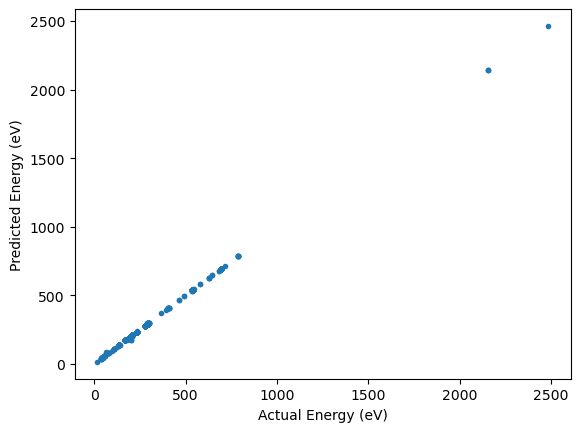

In [23]:
plt.plot(df["Act"], df["Pred"], ".")
plt.xlabel("Actual Energy (eV)")
plt.ylabel("Predicted Energy (eV)")

Text(0, 0.5, 'Predicted Energy (eV)')

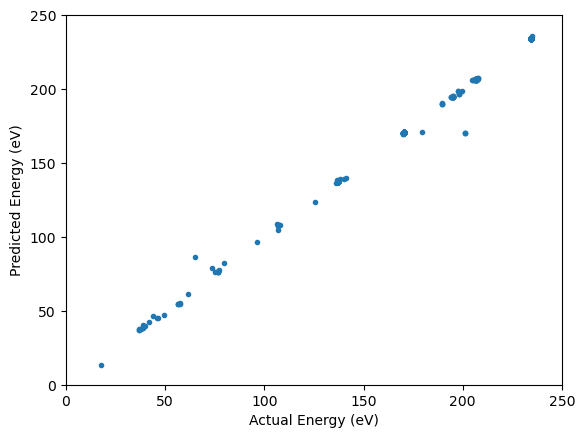

In [24]:
plt.plot(df["Act"], df["Pred"], ".")
plt.ylim(0,250)
plt.xlim(0,250)
plt.xlabel("Actual Energy (eV)")
plt.ylabel("Predicted Energy (eV)")